# Import Libraries

In [1]:
# ====== 0) SETUP ======
!pip -q install --upgrade pandas seaborn matplotlib

import warnings, re, sys, subprocess
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


# 📥 1) Load data (Drive or upload) & normalize headers

In [2]:
# ====== 1) LOAD DATA ======
# EITHER mount Drive ...
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# <-- update ONLY this path if your file lives elsewhere -->
CSV_PATH = "/content/drive/MyDrive/ML_Project/COLLEGE EVENT FEEDBACK ANALYSIS – INTERNSHIP PROJECT/student_feedback.csv"

# ... OR use manual upload (uncomment these 2 lines instead of Drive path above)
# from google.colab import files
# uploaded = files.upload(); CSV_PATH = list(uploaded.keys())[0]

# Robust read (handles Excel/Sheets exports)
df_raw = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
df = df_raw.copy()

print("Original columns:", list(df.columns))

# Normalize headers: lower, trim, snake_case
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r'[^a-z0-9]+', '_', regex=True))
# Drop duplicate header names if normalization collided
df = df.loc[:, ~df.columns.duplicated()]

# Drop any auto index columns like 'unnamed_0'
drop_like = [c for c in df.columns if c.startswith('unnamed')]
if drop_like: df = df.drop(columns=drop_like)

print("Normalized columns:", list(df.columns))
df.head(3)


Mounted at /content/drive
Original columns: ['Unnamed: 0', 'Student ID', 'Well versed with the subject', 'Explains concepts in an understandable way', 'Use of presentations', 'Degree of difficulty of assignments', 'Solves doubts willingly', 'Structuring of the course', 'Provides support for students going above and beyond', 'Course recommendation based on relevance']
Normalized columns: ['student_id', 'well_versed_with_the_subject', 'explains_concepts_in_an_understandable_way', 'use_of_presentations', 'degree_of_difficulty_of_assignments', 'solves_doubts_willingly', 'structuring_of_the_course', 'provides_support_for_students_going_above_and_beyond', 'course_recommendation_based_on_relevance']


,student_id,well_versed_with_the_subject,explains_concepts_in_an_understandable_way,use_of_presentations,degree_of_difficulty_of_assignments,solves_doubts_willingly,structuring_of_the_course,provides_support_for_students_going_above_and_beyond,course_recommendation_based_on_relevance
0,340,5,2,7,6,9,2,1,8
1,253,6,5,8,6,2,1,2,9
2,680,7,7,6,5,4,2,3,1


# 🧼 2) Identify rating columns & clean to numeric


In [3]:
# ====== 2) RATING COLUMNS & CLEANING ======
# Treat these as non-rating identifiers if present
non_rating_cols = {'student_id','name','email','roll_no','roll_number','timestamp'}

rating_cols = [c for c in df.columns if c not in non_rating_cols]

# Common text-Likert → numeric mapping (case-insensitive)
likert_map = {
    'strongly disagree':1, 'disagree':2, 'neutral':3, 'agree':4, 'strongly agree':5,
    'very poor':1, 'poor':2, 'average':3, 'good':4, 'excellent':5,
    'very difficult':1, 'difficult':2, 'moderate':3, 'easy':4, 'very easy':5,
    'never':1, 'rarely':2, 'sometimes':3, 'often':4, 'always':5
}

def to_numeric_series(s: pd.Series) -> pd.Series:
    s = s.astype(str)
    # 1) try extracting numbers like "4", "4/5", "5 stars"
    num = s.str.extract(r'(\d+(\.\d+)?)', expand=False)[0]
    if num.notna().any():
        out = pd.to_numeric(num, errors='coerce')
    else:
        # 2) fall back to mapping common Likert words
        out = s.str.lower().map(likert_map)
    return out

for c in rating_cols:
    df[c] = to_numeric_series(df[c])

# Keep only columns that turned into (mostly) numeric
rating_cols = [c for c in rating_cols if pd.api.types.is_numeric_dtype(df[c])]

# Basic cleaning
df = df.dropna(how='all', subset=rating_cols).copy()
df[rating_cols] = df[rating_cols].clip(lower=1, upper=5)  # keep 1..5 bounds

print(f"Rating columns ({len(rating_cols)}):", rating_cols)
df[rating_cols].describe().T[['mean','std','min','max']]


Rating columns (8): ['well_versed_with_the_subject', 'explains_concepts_in_an_understandable_way', 'use_of_presentations', 'degree_of_difficulty_of_assignments', 'solves_doubts_willingly', 'structuring_of_the_course', 'provides_support_for_students_going_above_and_beyond', 'course_recommendation_based_on_relevance']


,mean,std,min,max
well_versed_with_the_subject,5.000000,0.000000,5.0,5.0
explains_concepts_in_an_understandable_way,4.346653,1.056746,2.0,5.0
use_of_presentations,4.782218,0.412945,4.0,5.0
degree_of_difficulty_of_assignments,3.972028,1.419583,1.0,5.0
solves_doubts_willingly,3.987013,1.433468,1.0,5.0
structuring_of_the_course,4.033966,1.412390,1.0,5.0
provides_support_for_students_going_above_and_beyond,4.045954,1.393516,1.0,5.0
course_recommendation_based_on_relevance,4.029970,1.412480,1.0,5.0


# 📊 3) KPIs (overall & recommendation)

Remove duplicates if any

Handle missing values (drop or fill)

Convert ratings to integer type

In [4]:
# ====== 3) KPIs ======
N = len(df)
overall_score = df[rating_cols].mean(axis=1)
df['overall_score'] = overall_score

kpi = {
    "responses": int(N),
    "avg_overall": float(round(overall_score.mean(), 2)),
    "std_overall": float(round(overall_score.std(), 2)),
    "pct_overall_>=4": float(round((overall_score >= 4).mean()*100, 1))
}

# If a recommendation-type column exists, report %
rec_candidates = [c for c in rating_cols if 'recommend' in c or 'recommendation' in c]
rec_col = rec_candidates[0] if rec_candidates else None
if rec_col:
    kpi["pct_recommend_4_5"] = float(round((df[rec_col] >= 4).mean()*100, 1))

kpi


{'responses': 1001,
 'avg_overall': 4.27,
 'std_overall': 0.42,
 'pct_overall_>=4': 79.2,
 'pct_recommend_4_5': 71.5}

# 🥇 4) Strengths & improvement areas (question means)

In [5]:
# ====== 4) PER-QUESTION MEANS ======
mean_per_q = df[rating_cols].mean().sort_values(ascending=False).to_frame("mean_score")

top3 = mean_per_q.head(3).copy()
bottom3 = mean_per_q.tail(3).copy()

print("Top strengths (mean score):")
display(top3)

print("Improvement opportunities (mean score):")
display(bottom3)


Top strengths (mean score):


,mean_score
well_versed_with_the_subject,5.000000
use_of_presentations,4.782218
explains_concepts_in_an_understandable_way,4.346653


Improvement opportunities (mean score):


,mean_score
course_recommendation_based_on_relevance,4.029970
solves_doubts_willingly,3.987013
degree_of_difficulty_of_assignments,3.972028


# 📈 5) Visuals (one chart per cell)

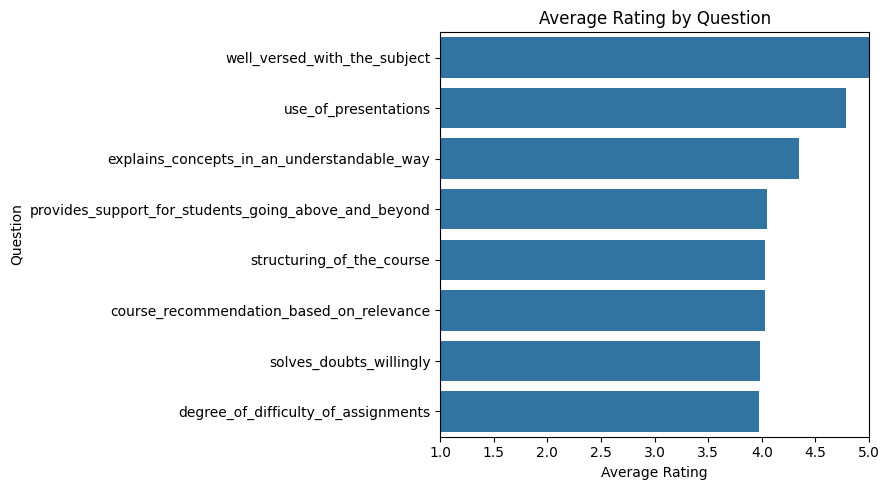

In [6]:
# ====== 5a) Average by Question (bar) ======
plt.figure(figsize=(9,5))
sns.barplot(x=mean_per_q['mean_score'], y=mean_per_q.index)
plt.xlabel("Average Rating")
plt.ylabel("Question")
plt.title("Average Rating by Question")
plt.xlim(1,5)
plt.tight_layout()
plt.show()


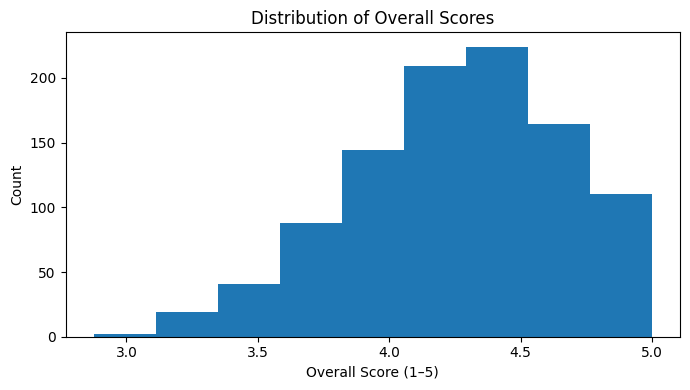

In [7]:
# ====== 5b) Overall Score Distribution ======
plt.figure(figsize=(7,4))
plt.hist(df['overall_score'].dropna(), bins=9)
plt.xlabel("Overall Score (1–5)")
plt.ylabel("Count")
plt.title("Distribution of Overall Scores")
plt.tight_layout()
plt.show()


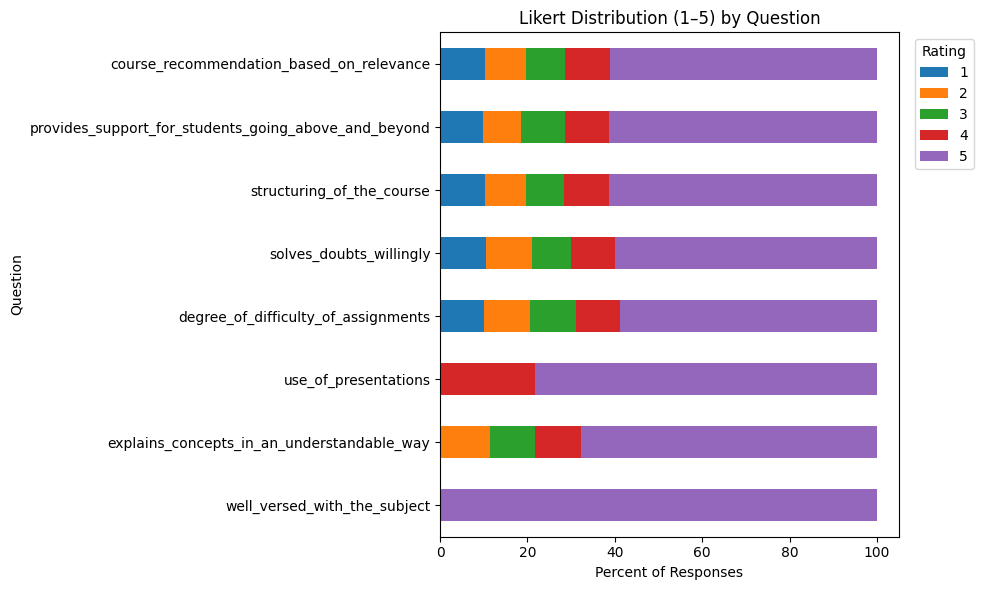

In [8]:
# ====== 5c) Likert Stacked Distribution (1–5) per Question ======
order = [1,2,3,4,5]
dist = (df[rating_cols]
        .apply(lambda s: s.value_counts(normalize=True).reindex(order).fillna(0))
        .T*100).round(1)

ax = dist.plot(kind='barh', stacked=True, figsize=(10,6))
plt.legend(title='Rating', bbox_to_anchor=(1.02,1), loc='upper left')
plt.xlabel("Percent of Responses")
plt.ylabel("Question")
plt.title("Likert Distribution (1–5) by Question")
plt.tight_layout()
plt.show()


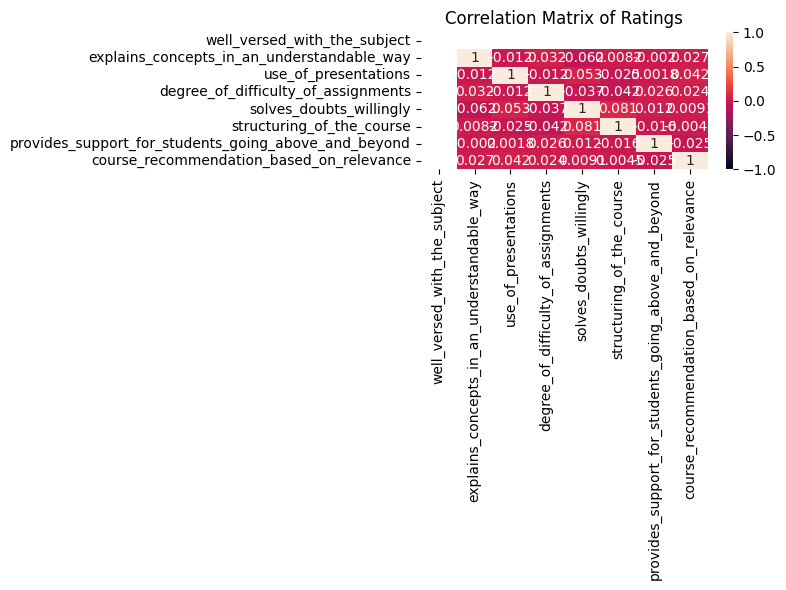

Correlations with recommendation (higher ⇒ stronger driver):


,course_recommendation_based_on_relevance
course_recommendation_based_on_relevance,1.000000
use_of_presentations,0.042061
explains_concepts_in_an_understandable_way,0.026531
degree_of_difficulty_of_assignments,0.024357
solves_doubts_willingly,0.009082
structuring_of_the_course,-0.004521
provides_support_for_students_going_above_and_beyond,-0.025087
well_versed_with_the_subject,NaN


In [9]:
# ====== 5d) Correlation Heatmap (drivers) ======
corr = df[rating_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Ratings")
plt.tight_layout()
plt.show()

if rec_col:
    corr_with_rec = corr[rec_col].sort_values(ascending=False)
    print("Correlations with recommendation (higher ⇒ stronger driver):")
    display(corr_with_rec)


# 🏷️ 6) Sentiment-like labels from overall score (optional)

In [10]:
# ====== 6) OVERALL SENTIMENT BUCKETS (from numeric score) ======
def bucket(x):
    if pd.isna(x): return np.nan
    if x >= 4: return "Positive"
    if x <= 2: return "Negative"
    return "Neutral"

df['sentiment_bucket'] = df['overall_score'].apply(bucket)
sentiment_pct = df['sentiment_bucket'].value_counts(normalize=True).mul(100).round(1)
print("Overall sentiment buckets (%):")
sentiment_pct


Overall sentiment buckets (%):


,proportion
sentiment_bucket,
Positive,79.2
Neutral,20.8


# 📝 7) OPTIONAL: True text sentiment (runs only if a free‑text column exists)

In [11]:
# ====== 7) OPTIONAL: TRUE TEXT SENTIMENT (if you later add a comments column) ======
# Try to detect a free-text column; if none, this section will just skip.
text_candidates = ['feedback','comment','comments','review','reviews','text',
                   'remarks','suggestions','message','response','open_ended_response',
                   'your_feedback','please_share_your_feedback']
text_col = next((c for c in df.columns if c in text_candidates), None)

if text_col:
    print(f"Found text column: {text_col}")
    # Ensure NLTK VADER is available
    import nltk
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    df['text'] = df[text_col].astype(str)
    df['sentiment_score_text'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
    df['sentiment_text'] = df['sentiment_score_text'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

    # Install wordcloud only if needed
    try:
        from wordcloud import WordCloud
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
        from wordcloud import WordCloud

    text_combined = " ".join(df['text'].astype(str).tolist())
    wc = WordCloud(width=900, height=400, background_color="white").generate(text_combined)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Feedback")
    plt.tight_layout()
    plt.show()

    # Sentiment distribution from text
    plt.figure(figsize=(5,4))
    df['sentiment_text'].value_counts().plot(kind='bar')
    plt.title("Text Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No free-text/feedback column detected. Skipping NLP; numeric analysis is complete.")


No free-text/feedback column detected. Skipping NLP; numeric analysis is complete.


# 💾 8) Save cleaned data for dashboarding (Power BI / further work)

In [12]:
# ====== 8) SAVE CLEANED OUTPUT ======
cols_to_save = (['student_id'] if 'student_id' in df.columns else []) + ['overall_score','sentiment_bucket'] + rating_cols
clean_path = "student_feedback_cleaned.csv"
df[cols_to_save].to_csv(clean_path, index=False)
print(f"Saved cleaned file to: {clean_path}")


Saved cleaned file to: student_feedback_cleaned.csv
